# YOLOv5






## Импорт библиотек

In [1]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями и построения модели
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
import cv2
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display

## Загрузка данных

In [2]:
# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

In [3]:
def xml_to_csv(path = 'VOCdevkit/VOC2012/Annotations/'):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [4]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010.csv', index=None)
print('Конвертация прошла успешно.')

100%|██████████| 3503/3503 [00:13<00:00, 258.88it/s]


Конвертация прошла успешно.


In [5]:
xml_df = xml_df[:100]

In [6]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_000001.jpg,3,333,500,cat,123,13,341,313
1,2010_000001.jpg,3,333,500,chair,294,13,410,236
2,2010_000001.jpg,3,333,500,chair,418,198,500,290
3,2010_000001.jpg,3,333,500,chair,362,1,498,80
4,2010_000001.jpg,3,333,500,diningtable,1,219,500,333


In [7]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 100
Количество изображений в датафрэйме 48


## Обработка данных 

Закодируем классы обьектов.

In [8]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

In [9]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_000001.jpg,3,333,500,7,123,13,341,313
1,2010_000001.jpg,3,333,500,8,294,13,410,236
2,2010_000001.jpg,3,333,500,8,418,198,500,290
3,2010_000001.jpg,3,333,500,8,362,1,498,80
4,2010_000001.jpg,3,333,500,10,1,219,500,333


Сохраним кодировку классов в переменной mapping.

In [10]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [11]:
mapping

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

Теперь нам нужно привести наши данные к формату **YOLOv5**.

Аннотация каждого объекта должна сожержать следующую информацию:

`Class X Y Width Height`

![picture](https://drive.google.com/uc?export=view&id=1yUJt5XTvYo4MbWxKAxhPdCk-yCnQ1AEz)


Для этого воспользуемся вспомогательной функцией `convert_to_yolov5`.



In [12]:
def convert_to_yolov5(df, unique_img_names):

    df_array = np.array(df)

    # Для каждого объкта
    for i in range(len(df)):
        print_buffer = []

        point =  df_array[i]
        img_name = point[0]

        # Для каждого уникального изображения
        for unique_img_name in unique_img_names:
           if img_name == unique_img_name:
              class_id = point[4]
      
              # Преобразуем координаты bbox 
              X = (point[5] + point[7]) / 2 
              Y = (point[6] + point[8]) / 2 
              Width    = (point[7] - point[5])
              Height   = (point[8] - point[6])
              
              # Нормализуем координаты
              image_c, image_w, image_h = point[1], point[2], point[3] 
              X /= image_w 
              Y /= image_h 
              Width    /= image_w 
              Height   /= image_h 
              
              # Запишем информацию о bbox в файл
              print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))
              
        # Дадим имя файлам, которые хотим сохранить
        save_file_name = os.path.join("VOCdevkit/VOC2012/JPEGImages/", img_name.replace("jpg", "txt"))
        
        # Сохраним аннотации на диск
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [13]:
# Для начала выделим список уникальных имен изображений
unique_img_names = xml_df['filename'].unique()
print(len(unique_img_names))

48


In [14]:
# Получим аннотации в новом формате
convert_to_yolov5(xml_df, unique_img_names)

Давайте протестируем трансформированные аннотиции с помощью визуализации.

In [15]:
class_id_to_name_mapping = dict(zip(mapping.values(), mapping.keys()))

In [16]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))], fill="#000")
    
    
    plt.imshow(np.array(image))
    plt.show()

In [17]:
# Выберем рандомную аннотацию 
annotation_random= !ls VOCdevkit/VOC2012/JPEGImages/*txt | shuf -n 1

txtPath = "VOCdevkit/VOC2012/JPEGImages/2010_000002.txt"
with open(f'./{txtPath}', "r") as file:
    annotation_random = file.read().strip()

In [18]:
annotation_random

'16 0.597 0.446 0.719 0.708'

[[16.     0.597  0.446  0.719  0.708]]


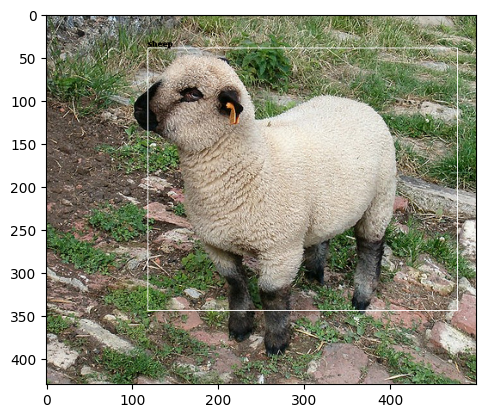

In [19]:
# Выберем рандомную аннотацию 
annotation_file = txtPath#annotation_random[0]
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

Обученная модель находится в классе hub библиотеки `torch`.

Давайте посмотрим на предсказания модели для нашей рандомной картинки.

In [20]:
jpgPath = "./VOCdevkit/VOC2012/JPEGImages/2010_000002.jpg"

In [21]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s') 

img = annotation_random[0].replace("txt", "jpg")

# Inference
results = model(jpgPath)

# Results
results.print()

Using cache found in C:\Users\ilkhom-pc/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-3-16 Python-3.9.16 torch-1.10.1+cu113 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
image 1/1: 430x500 1 sheep
Speed: 11.0ms pre-process, 23.0ms inference, 8.0ms NMS per image at shape (1, 3, 576, 640)


## ЗАДАНИЕ

Обучите модель **yolov5**,  используя готовый `train.py` файл репозитория https://github.com/ultralytics/yolov5.git.

Для данной модели изображения и классы объектов должны находиться в папках images и labels, соответсвенно.

Протестируйте модель на валидациооной выборке и выведите на экран полученные изображения с bbox и классами объектов.

In [23]:
#--- YOUR CODE HERE ---
!python ./yolov5/train.py --data voc.yaml --weights yolov5s.pt --img 640  # from pretrained (recommended)

wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: thenexus85. Use `wandb login --relogin` to force relogin
usage: train.py [-h] [--weights WEIGHTS] [--cfg CFG] [--data DATA] [--hyp HYP]
                [--epochs EPOCHS] [--batch-size BATCH_SIZE] [--imgsz IMGSZ]
                [--rect] [--resume [RESUME]] [--nosave] [--noval]
                [--noautoanchor] [--noplots] [--evolve [EVOLVE]]
                [--bucket BUCKET] [--cache [CACHE]] [--image-weights]
                [--device DEVICE] [--multi-scale] [--single-cls]
                [--optimizer {SGD,Adam,AdamW}] [--sync-bn] [--workers WORKERS]
                [--project PROJECT] [--name NAME] [--exist-ok] [--quad]
                [--cos-lr] [--label-smoothing LABEL_SMOOTHING]
                [--patience PATIENCE] [--freeze FREEZE [FREEZE ...]]
                [--save-period SAVE_PERIOD] [--se

Сделайте сравнение текущей модели с Faster RCNN по скорости и качетсву.